# How to plot transect

Example is for fesom, but with some minimal adjustments should work for any unstryctured or structured meshes.

In [19]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import intake
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
sys.path.append("../../")
import nereus as nr

Open catalog and data

In [20]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [21]:
data = cat["FESOM"]['IFS_4.4-FESOM_5-cycle3']['3D_daily_native_zarr'].to_dask()

We are going to work with daily 3D data on native grid

In [22]:
data

<xarray.Dataset>
Dimensions:  (nz1: 69, time: 1808, nod2: 7402886, elem: 14741520, nz: 70)
Coordinates:
  * nz1      (nz1) float64 2.5 7.5 12.5 17.5 ... 5.525e+03 5.825e+03 6.175e+03
  * time     (time) datetime64[ns] 2020-01-20T23:56:00 ... 2024-12-31T23:56:00
  * nz       (nz) float64 0.0 5.0 10.0 15.0 ... 5.4e+03 5.65e+03 6e+03 6.35e+03
Dimensions without coordinates: nod2, elem
Data variables:
    salt     (time, nz1, nod2) float32 dask.array<chunksize=(12, 5, 1000000), meta=np.ndarray>
    temp     (time, nz1, nod2) float32 dask.array<chunksize=(12, 5, 1000000), meta=np.ndarray>
    u        (time, nz1, elem) float32 dask.array<chunksize=(12, 5, 1000000), meta=np.ndarray>
    v        (time, nz1, elem) float32 dask.array<chunksize=(12, 5, 1000000), meta=np.ndarray>
    w        (time, nz, nod2) float32 dask.array<chunksize=(12, 5, 1000000), meta=np.ndarray>

We also would need infromation about coordinates of our points (we call them nodes):

In [23]:
ocean_mesh = cat.FESOM['IFS_4.4-FESOM_5-cycle3']['node_grid'].to_dask()

Load lons and lats of all grid points:

In [24]:
node_lons = ocean_mesh.grid_center_lon.values
node_lats = ocean_mesh.grid_center_lat.values

Define the transect. Here we define a strait line, and `nereus` function `transect_get_lonlat` only create strait lines, but in principle you can provide any set of lon/lat coordinates

In [25]:
lon_start = -70
lat_start = 31
lon_end = -70
lat_end = 38
npoints   = 100 # number of points along transect
# we get set of lon/lat coordinates fo 100 points
lonlat = nr.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

This function returns indexes of model grid points, that are closest to the transect points we just get:

In [26]:
nodes_ocean = nr.transect_get_nodes(lonlat, node_lons, node_lats)

This fucntion finds distance in km between the points

In [25]:
dist = nr.transect_get_distance(lonlat)

Let's plot coordinates of points we want to get, and coordinates of nearest neighbors from the model grid:

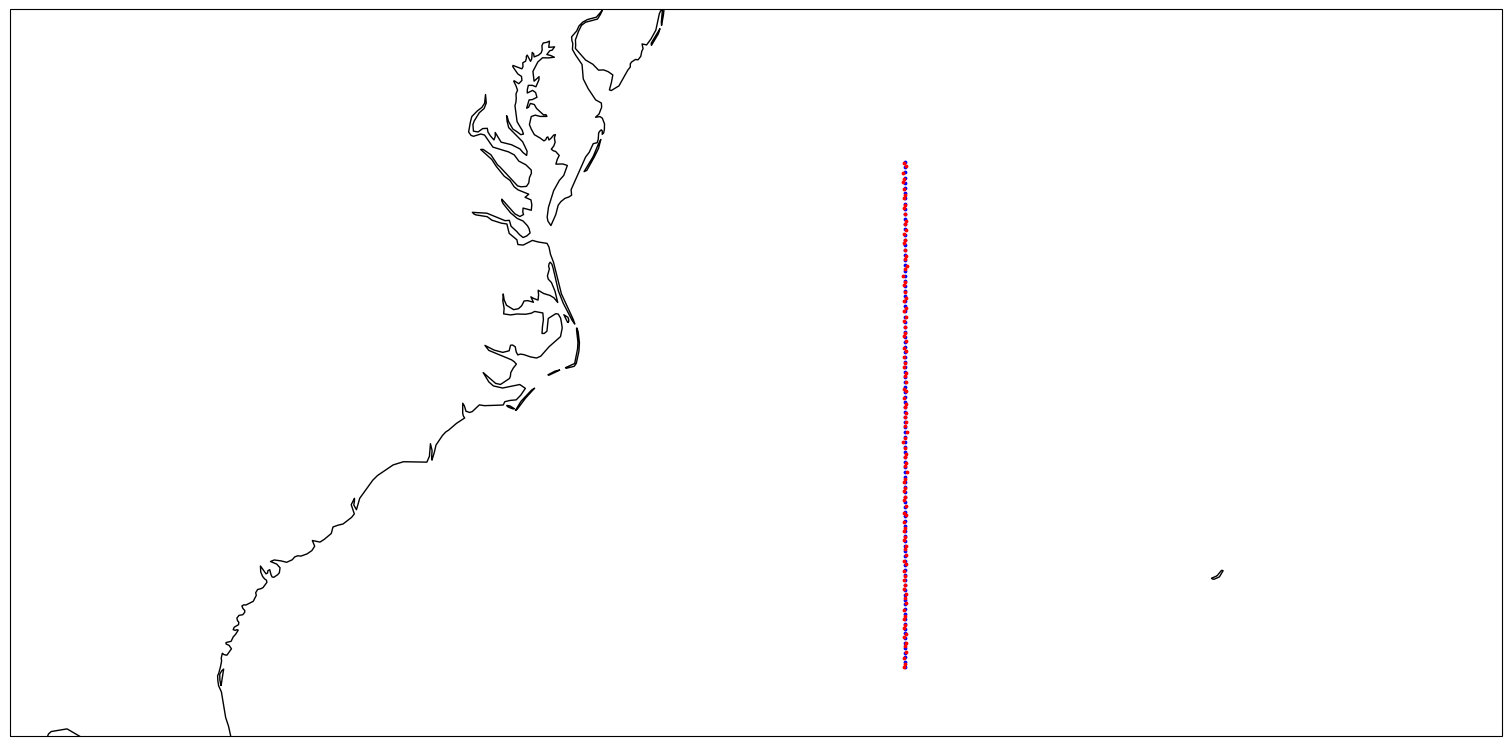

In [26]:
bbox = [-85, -60, 30, 40]
point_size = 3

fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.Mercator()),
            constrained_layout=True,
            figsize=(15,10),
        )
ax.set_extent(bbox, crs=ccrs.PlateCarree())
ax.scatter(lonlat[0, :], lonlat[1, :], s=point_size, c="b", transform=ccrs.PlateCarree())
ax.scatter(
        ocean_mesh.grid_center_lon.values[nodes_ocean], ocean_mesh.grid_center_lat.values[nodes_ocean], s=point_size, c="r",
    transform=ccrs.PlateCarree()
    )
ax.coastlines("50m")

Now we can just select the model points by index:

In [27]:
oc_data = data['temp'][1,:,:].values[:,nodes_ocean]

And plot it (here only first 40 levels are plotted)

Text(0, 0.5, 'Depth, m')

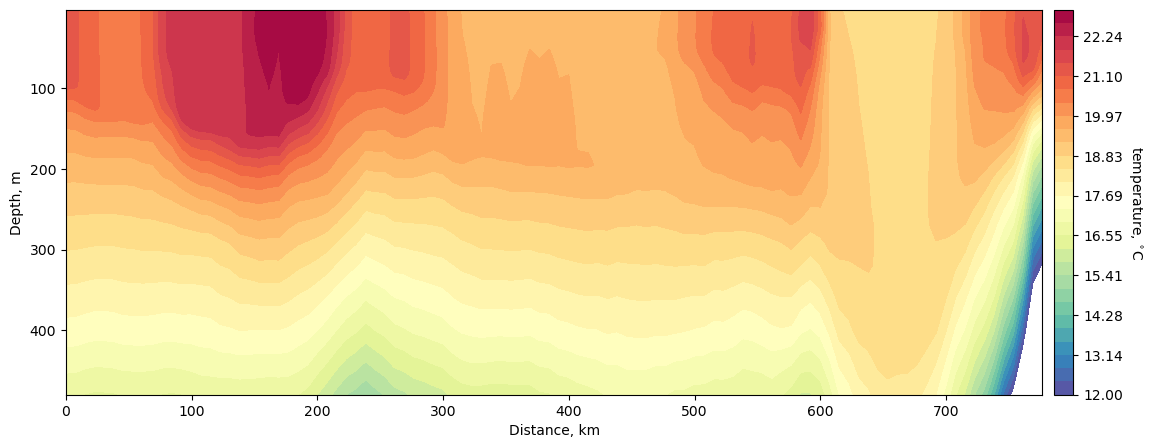

In [12]:
plt.figure(figsize=(15,5))
ax = plt.gca()
im = ax.contourf(dist, data.nz1.values[0:40], oc_data[0:40,:], 
                 levels=np.linspace(12,23,30), 
                 cmap=cm.Spectral_r)
ax.invert_yaxis()
cbar = plt.colorbar(im, pad=0.01)
cbar.set_label('temperature, $^{\circ}$C', rotation=270, labelpad=15)
ax.set_xlabel('Distance, km')
ax.set_ylabel('Depth, m')

What if we would like to have a movie with transect values. Here we get the data from first 10 time steps:

In [14]:
%%time
data_interpolated_array = []
for i in range(10):
    timestep = data['temp'][i,:,:].values # yes. it's faster to load the data to the memory and then select points 
    oc_data = timestep[:,nodes_ocean]
    data_interpolated_array.append(oc_data)
    print(i)

0
1
2
3
4
5
6
7
8
9
CPU times: user 2min 48s, sys: 33min 4s, total: 35min 53s
Wall time: 52.4 s


Convert list to numpy array:

In [15]:
data_interpolated_array = np.array(data_interpolated_array, dtype="float32")

Convertion of list to numpy array may result in array of different shapes. We want to have `[time, depth, distance]` shape:

In [28]:
data_interpolated_array.shape

(10, 69, 102)

In [17]:
# if dimensions of your array are not [time, depth, distance], you can reshape it:
# data_interpolated_array = np.transpose(data_interpolated_array, (0, 2, 1))

Create xarray and save to netCDF:

In [19]:
out = xr.Dataset(
        {"temperature_transect": (["time",  "depth", "distance"], data_interpolated_array)},
        coords={
            "time": data['temp'].time[:10].values,
            "depth": (["depth"], data.nz1.values*-1),
            "distance": (["distance"], dist),
        },
        # attrs=data.attrs,
    )

In [20]:
out.to_netcdf('./trans.nc')